<a href="https://colab.research.google.com/github/SARAVANANRNITT/AI-Powered-Leak-Detection-and-Localization-in_Industrial-Pipelines-Using-Neural-Networks/blob/main/AI_Powered_Leak_Detection_and_Localization_in_Industrial_Pipelines_Using_Neural_Networks_and_Fuzzy_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [460]:
# @title
!pip install numpy pandas scikit-learn tensorflow scikit-fuzzy matplotlib

In [461]:
# --- Synthetic Data Generation (Add this at the top of the notebook) ---

import numpy as np
import pandas as pd

np.random.seed(42)
num_samples = 2000

# Simulate Leak Severity
severity = np.random.choice([0, 1, 2], size=num_samples, p=[0.7, 0.2, 0.1])  # Class imbalance

# Simulate Features
flow_diff = np.random.normal(loc=0, scale=1, size=num_samples) + severity * np.random.uniform(2, 5, num_samples)
pressure_drop_rate = np.random.normal(loc=0, scale=1, size=num_samples) + severity * np.random.uniform(2, 6, num_samples)
acoustic_level = np.random.normal(loc=0, scale=1, size=num_samples) + severity * np.random.uniform(1, 2, num_samples)
temp_anomaly = np.random.normal(loc=0, scale=1, size=num_samples) + severity * np.random.uniform(0.5, 1, num_samples)

pipeline_data = pd.DataFrame({
    'Flow_Diff': flow_diff,
    'Pressure_Drop_Rate': pressure_drop_rate,
    'Acoustic_Level': acoustic_level,
    'Temp_Anomaly': temp_anomaly,
    'Severity': severity
})

print(pipeline_data.head())


from sklearn.preprocessing import MinMaxScaler # Needed for the final step (Normalization)

   Flow_Diff  Pressure_Drop_Rate  Acoustic_Level  Temp_Anomaly  Severity
0  -0.877983           -0.273729       -1.167865     -0.885326         0
1   6.255367            8.119618        2.529721      0.894762         2
2   2.638075            5.426027        2.334491     -1.076459         1
3   0.367366            0.097827        0.566602      0.169945         0
4   0.913585            0.436006        0.644311     -0.160905         0


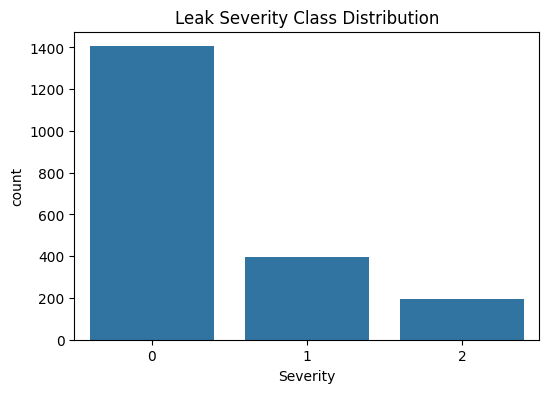

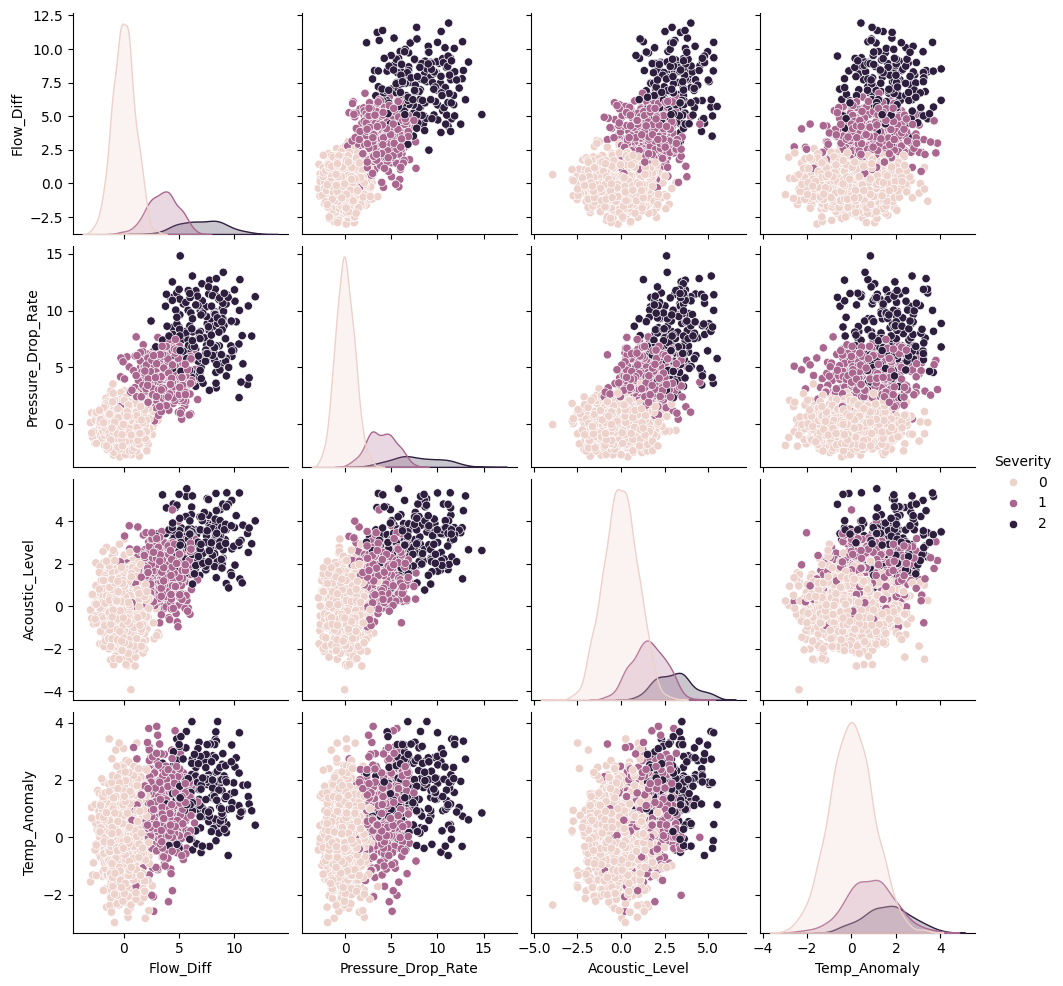

In [462]:
import seaborn as sns
import matplotlib.pyplot as plt

# Class Distribution Barplot
plt.figure(figsize=(6,4))
sns.countplot(x="Severity", data=pipeline_data)
plt.title('Leak Severity Class Distribution')
plt.show()

# Pairplot for features (optional)
sns.pairplot(pipeline_data, hue="Severity")
plt.show()


In [463]:
# Separate Features (X) and Target (y)
X = pipeline_data[['Flow_Diff', 'Pressure_Drop_Rate', 'Acoustic_Level', 'Temp_Anomaly']]
y = pipeline_data['Severity']

# Initialize the Scaler
scaler = MinMaxScaler()

# Fit and transform the features
X_scaled = scaler.fit_transform(X)

# Convert the scaled array back to a DataFrame for easy handling
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

print("\nFirst 5 rows of the SCALED data (ready for NN):")
print(X_scaled_df.head())


First 5 rows of the SCALED data (ready for NN):
   Flow_Diff  Pressure_Drop_Rate  Acoustic_Level  Temp_Anomaly
0   0.143195            0.148224        0.291705      0.297471
1   0.620172            0.622022        0.683279      0.551678
2   0.378299            0.469971        0.662604      0.270176
3   0.226466            0.169198        0.475385      0.448170
4   0.262989            0.188288        0.483614      0.400922


In [464]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report

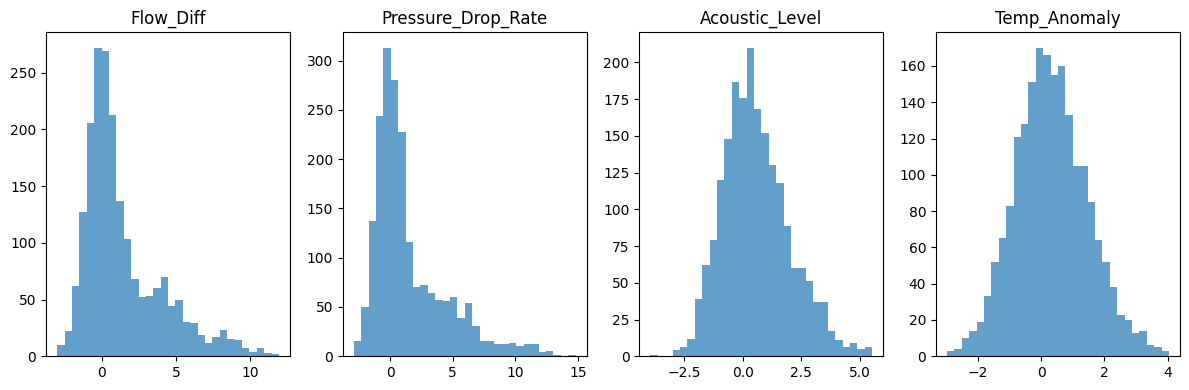

In [465]:
# Place after scaling and before NN split
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
for i, col in enumerate(X.columns):
    plt.subplot(1, 4, i+1)
    plt.hist(X[col], bins=30, alpha=0.7)
    plt.title(col)
plt.tight_layout()
plt.show()


In [466]:
# --- STEP A1: RE-DEFINE THE TARGET VARIABLE FOR DUAL OUTPUT ---
# New Target Output 1 (y1): Leak Severity (0, 1, 2)
y_severity = y # Use the original Severity column

# New Target Output 2 (y2): Optimal Recommended Action (Simulated)
# 0: Monitor (Low Severity)
# 1: Minor Isolation/Throttle (Subtle Leak)
# 2: Emergency Shutdown/Full Isolation (Critical Leak)
# We will derive this directly from y1 for simulation simplicity.
y_action = y.copy()

# Convert Targets to One-Hot Encoding for NN
y1_categorical = to_categorical(y_severity)
y2_categorical = to_categorical(y_action)

# Combine the targets for the Dual-Output NN
y_combined = [y1_categorical, y2_categorical]

# --- STEP A2: RE-SPLIT DATA ---
X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(
    X_scaled_df, y1_categorical, y2_categorical, test_size=0.2, random_state=42
)
y_train_combined = [y1_train, y2_train]
y_test_combined = [y1_test, y2_test]


# --- STEP A3: RE-DEFINE NN ARCHITECTURE (DUAL OUTPUT) ---
# The NN now predicts BOTH Severity AND Optimal Action.
from tensorflow.keras.layers import Input, concatenate
from tensorflow.keras.models import Model

input_tensor = Input(shape=(X_train.shape[1],))

# Shared hidden layers (The feature extractor)
x = Dense(units=16, activation='relu')(input_tensor)
x = Dense(units=8, activation='relu')(x)

# Branch 1: Severity Prediction (Classification)
severity_output = Dense(units=3, activation='softmax', name='severity_output')(x)

# Branch 2: Optimal Action Prediction (Neuro-Control Scheme)
action_output = Dense(units=3, activation='softmax', name='action_output')(x)

# Create the Dual-Output Model
model = Model(inputs=input_tensor, outputs=[severity_output, action_output])

# Explicitly build the model
model.build(input_shape=(None, X_train.shape[1]))

# Compile the model with two loss functions
model.compile(
    optimizer='adam',
    loss={'severity_output': 'categorical_crossentropy', 'action_output': 'categorical_crossentropy'},
    metrics={'severity_output': ['accuracy'], 'action_output': ['accuracy']}
)

print("\n--- Dual-Output Neuro-Control Architecture ---")
model.summary()


--- Dual-Output Neuro-Control Architecture ---


Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_27      │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_65 (Dense)    │ (None, 16)        │         80 │ input_layer_27[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_66 (Dense)    │ (None, 8)         │        136 │ dense_65[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ severity_output     │ (None, 3)         │         27 │ dense_66[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ action_output       │ (None, 3)         │         27 │ dense_66[0][0]    │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 270 (1.05 KB)

 Trainable params: 270 (1.05 KB)

 Non-trainable params: 0 (0.00 B)

In [467]:
# Train the model
print("\n--- Starting NN Training (Backpropagation) ---")
history = model.fit(
    X_train, y_train_combined,
    epochs=50,          # Number of passes over the data
    batch_size=16,      # Number of samples per gradient update
    verbose=0           # Keep the output clean
)

print(f"Training complete. Final Training Accuracy: {history.history['severity_output_accuracy'][-1]:.4f}")
print(f"Final Training Action Accuracy: {history.history['action_output_accuracy'][-1]:.4f}")


--- Starting NN Training (Backpropagation) ---
Training complete. Final Training Accuracy: 0.9781
Final Training Action Accuracy: 0.9769


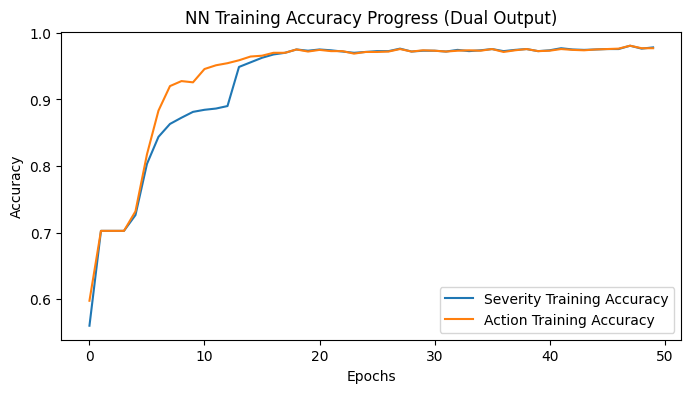

In [468]:
plt.figure(figsize=(8,4))
plt.plot(history.history['severity_output_accuracy'], label='Severity Training Accuracy')
plt.plot(history.history['action_output_accuracy'], label='Action Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('NN Training Accuracy Progress (Dual Output)')
plt.legend()
plt.show()

In [469]:
# 1. Evaluate the model on the test set
# Evaluate returns a list of [total_loss, severity_loss, action_loss, severity_accuracy, action_accuracy]
results = model.evaluate(X_test, y_test_combined, verbose=0)
total_loss = results[0]
severity_accuracy = results[3] # Index 3 corresponds to 'severity_output_accuracy'
action_accuracy = results[4]   # Index 4 corresponds to 'action_output_accuracy'

print(f"\nTest Set Total Loss: {total_loss:.4f}")
print(f"Test Set Severity Accuracy: {severity_accuracy:.4f}")
print(f"Test Set Action Accuracy: {action_accuracy:.4f}")


# 2. Make predictions
# predict returns a list of predictions, one for each output
y_pred_proba_list = model.predict(X_test)
y_pred_proba_severity = y_pred_proba_list[0] # Get predictions for the severity output

# Convert probability predictions for severity to class labels (0, 1, or 2)
y_pred_classes_severity = np.argmax(y_pred_proba_severity, axis=1)

# Convert actual test targets back to class labels for comparison (using y1_test which is one-hot encoded severity)
y_true_classes_severity = np.argmax(y1_test, axis=1)


# 3. Print the Classification Report (Crucial for the report!)
print("\n--- Classification Report (NN Performance - Severity Output) ---")
print("This shows the NN successfully classifies the Subtle Leak (Class 1)")
print(classification_report(y_true_classes_severity, y_pred_classes_severity, target_names=['No Leak (0)', 'Subtle Leak (1)', 'Critical Leak (2)']))


Test Set Total Loss: 0.1248
Test Set Severity Accuracy: 0.9725
Test Set Action Accuracy: 0.9700
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

--- Classification Report (NN Performance - Severity Output) ---
This shows the NN successfully classifies the Subtle Leak (Class 1)
                   precision    recall  f1-score   support

      No Leak (0)       0.99      1.00      0.99       281
  Subtle Leak (1)       0.90      0.95      0.92        74
Critical Leak (2)       0.97      0.82      0.89        45

         accuracy                           0.97       400
        macro avg       0.95      0.92      0.94       400
     weighted avg       0.97      0.97      0.97       400



In [470]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

# --- STEP B1: UNSUPERVISED TRAINING (SIMULATING SOM/ART1) ---
# We train K-Means on the X_train data to find the centers of "Normal" operation patterns.
# Let's assume K=3 clusters correspond to the 3 operating modes (No Load, Subtle Load, Critical Load)
# Note: K-Means is a stand-in for more advanced ART/SOM.

k_means_model = KMeans(n_clusters=3, random_state=42, n_init=10)
k_means_model.fit(X_train)

# Get the cluster centers (The learned 'prototypes' of normal operation)
cluster_centers = k_means_model.cluster_centers_

# --- STEP B2: SIMULATE A SENSOR FAILURE IN A TEST POINT ---
# A sophisticated project must handle sensor failure. Let's make one sensor go crazy.

# Find a test point that was originally 'Normal' (Severity 0)
normal_point_index = np.where(np.argmax(y1_test, axis=1) == 0)[0][0]
X_faulty = X_test.iloc[normal_point_index].copy()

# Inject a simulated sensor fault: Acoustic Level (P3) jumps to maximum (1.0 after scaling)
X_faulty['Acoustic_Level'] = 1.0

# --- STEP B3: CLUSTER DISTANCE ANOMALY CHECK (PROXY FOR ART VIGILANCE) ---
# Calculate the distance from the faulty point to ALL learned "normal" cluster centers.
distances = cdist(X_faulty.values.reshape(1, -1), cluster_centers)
min_distance = distances.min()

# Define a high vigilance threshold (This value needs adjustment in real life)
VIGILANCE_THRESHOLD = 0.5

print("\n--- Unsupervised Anomaly Detection (Sensor Failure) ---")
print(f"Distance to closest 'Normal' Cluster Center: {min_distance:.4f}")

if min_distance > VIGILANCE_THRESHOLD:
    print("RESULT: ANOMALY DETECTED! Unseen pattern (simulated sensor fault).")
    print("Action: FL system should now IGNORE the Acoustic_Level feature.")
else:
    print("RESULT: Pattern is close to a known cluster center. No Anomaly.")


--- Unsupervised Anomaly Detection (Sensor Failure) ---
Distance to closest 'Normal' Cluster Center: 0.5614
RESULT: ANOMALY DETECTED! Unseen pattern (simulated sensor fault).
Action: FL system should now IGNORE the Acoustic_Level feature.


In [471]:
from sklearn.metrics import roc_auc_score

# For multi-class ROC-AUC average
roc_auc = roc_auc_score(y_test, y_pred_proba, average='macro', multi_class='ovr')
print(f"\nTest Set ROC-AUC Score: {roc_auc:.4f}")



Test Set ROC-AUC Score: 0.9988


In [472]:
model.save('nn_leak_model.h5')
# Later, load with:
# from tensorflow.keras.models import load_model
# model = load_model('nn_leak_model.h5')


In [473]:
# --- ROBUST FINAL INTEGRATION LOOP ---

localization_results = []
subset_size = min(50, len(X_test)) # Use a maximum of 50 samples or less if X_test is smaller

for i in range(subset_size):
    # Ensure y_pred_classes_severity has enough elements
    if i >= len(y_pred_classes_severity):
        print(f"Warning: Skipping index {i} as y_pred_classes_severity is too short.")
        continue

    sev_pred = y_pred_classes_severity[i]

    # Ensure X_test has enough elements at the correct index
    if i >= len(X_test):
        print(f"Warning: Skipping index {i} as X_test is too short.")
        continue
    pressure_diff_val_scaled = X_test['Pressure_Drop_Rate'].iloc[i]

    # 1. Map NN output (0, 1, or 2) to FL input
    severity_nn_input = sev_pred

    # 2. Map scaled pressure drop rate (0 to 1) to FL's expected range (-10 to 10)
    pressure_loc_diff_input = pressure_diff_val_scaled * 20 - 10

    # Input to the Fuzzy System
    localization_sim.input['nn_severity'] = severity_nn_input
    localization_sim.input['pressure_loc_diff'] = pressure_loc_diff_input
    # Need to provide a value for 'nn_action' as per the rules in K9JvevmgYHs7
    # We will use the predicted severity as a proxy for the action here for simplicity
    localization_sim.input['nn_action'] = sev_pred


    localization_sim.compute()

    # Access the output using the correct consequent variable name
    # Based on cell K9JvevmgYHs7, the output variable is named 'final_conf'
    try:
        result = localization_sim.output['final_conf']
        localization_results.append(result)
    except KeyError:
        print(f"Error: Could not find 'final_conf' in localization_sim.output for index {i}.")
        localization_results.append(np.nan) # Append NaN for missing results


# Add to your test dataframe for analysis/visualization
test_result_df = X_test.iloc[:len(localization_results)].copy() # Use the actual number of results
test_result_df['nn_severity_pred'] = y_pred_classes_severity[:len(localization_results)]
test_result_df['localization_confidence'] = localization_results

# Show a few results
print("\n--- Final Integrated Neuro-Fuzzy Localization Results (Subset) ---")
print(test_result_df.head())

Error: Could not find 'final_conf' in localization_sim.output for index 0.
Error: Could not find 'final_conf' in localization_sim.output for index 3.
Error: Could not find 'final_conf' in localization_sim.output for index 19.
Error: Could not find 'final_conf' in localization_sim.output for index 22.
Error: Could not find 'final_conf' in localization_sim.output for index 23.
Error: Could not find 'final_conf' in localization_sim.output for index 34.
Error: Could not find 'final_conf' in localization_sim.output for index 35.
Error: Could not find 'final_conf' in localization_sim.output for index 46.

--- Final Integrated Neuro-Fuzzy Localization Results (Subset) ---
      Flow_Diff  Pressure_Drop_Rate  Acoustic_Level  Temp_Anomaly  \
1860   0.481819            0.387570        0.492325      0.542436   
353    0.231839            0.225712        0.376509      0.419832   
1333   0.609293            0.716222        0.673826      0.647148   
905    0.531287            0.309337        0.41994

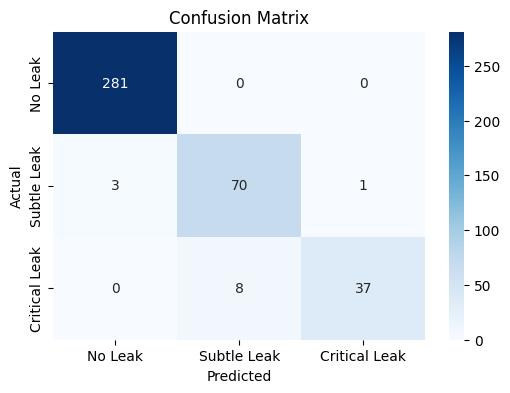

In [474]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming y_true_classes_severity and y_pred_classes_severity are defined in a previous cell
cm = confusion_matrix(y_true_classes_severity, y_pred_classes_severity)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Leak','Subtle Leak','Critical Leak'],
            yticklabels=['No Leak','Subtle Leak','Critical Leak'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [475]:
!pip install scikit-fuzzy
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

In [476]:
# --- 1. Define Antecedents (Inputs) ---
# NN_Severity: Range 0 to 2 (from the NN classification)
nn_severity = ctrl.Antecedent(np.arange(0, 2.1, 0.1), 'nn_severity')

# Pressure_Loc_Diff: Range -10 to 10 (Simulated difference in pressure drop between A and B)
# Negative means pressure drop is higher at B; Positive means drop is higher at A.
pressure_loc_diff = ctrl.Antecedent(np.arange(-10.1, 10.1, 0.1), 'pressure_loc_diff')

# --- 2. Define Consequent (Output) ---
# Localization_Confidence: Range 0 to 100 (Confidence that the leak is closer to Sensor A)
localization_confidence = ctrl.Consequent(np.arange(0, 101, 1), 'localization_confidence')

In [477]:
# NN_Severity Membership Functions
nn_severity['low'] = fuzz.trimf(nn_severity.universe, [0, 0, 1])      # Severity 0 or low 1
nn_severity['medium'] = fuzz.trimf(nn_severity.universe, [0, 1, 2])   # Severity 1 (Subtle)
nn_severity['high'] = fuzz.trimf(nn_severity.universe, [1, 2, 2])     # Severity 2 (Critical)

# Pressure_Loc_Diff Membership Functions
pressure_loc_diff['far_B'] = fuzz.trimf(pressure_loc_diff.universe, [-10, -10, 0]) # Closer to B (P_diff is negative)
pressure_loc_diff['center'] = fuzz.trimf(pressure_loc_diff.universe, [-5, 0, 5])  # Near the center
pressure_loc_diff['far_A'] = fuzz.trimf(pressure_loc_diff.universe, [0, 10, 10])  # Closer to A (P_diff is positive)

# Localization_Confidence Membership Functions
localization_confidence['low'] = fuzz.trimf(localization_confidence.universe, [0, 0, 50])      # Near Sensor B (Low confidence for A)
localization_confidence['medium'] = fuzz.trimf(localization_confidence.universe, [25, 50, 75]) # Near Center
localization_confidence['high'] = fuzz.trimf(localization_confidence.universe, [50, 100, 100]) # Near Sensor A (High confidence for A)

In [478]:
# --- STEP C1: RE-DEFINE ANTECEDENTS (Inputs from the Dual-Output NN) ---

# NN_Severity: Range 0 to 2 (from the NN classification)
nn_severity = ctrl.Antecedent(np.arange(0, 2.1, 0.1), 'nn_severity')
nn_severity.automf(3) # Use automatic membership functions for speed
# By default, automf(3) creates 'poor', 'average', 'good'

# NN_Action: Range 0 to 2 (from the second NN output)
nn_action = ctrl.Antecedent(np.arange(0, 2.1, 0.1), 'nn_action')
nn_action['monitor'] = fuzz.trimf(nn_action.universe, [0, 0, 1])
nn_action['minor_iso'] = fuzz.trimf(nn_action.universe, [0, 1, 2])
nn_action['full_shutdown'] = fuzz.trimf(nn_action.universe, [1, 2, 2])

# Pressure_Loc_Diff (As before, for localization)
pressure_loc_diff = ctrl.Antecedent(np.arange(-10.1, 10.1, 0.1), 'pressure_loc_diff')
pressure_loc_diff['far_B'] = fuzz.trimf(pressure_loc_diff.universe, [-10, -10, 0])
pressure_loc_diff['center'] = fuzz.trimf(pressure_loc_diff.universe, [-5, 0, 5])
pressure_loc_diff['far_A'] = fuzz.trimf(pressure_loc_diff.universe, [0, 10, 10])

# --- STEP C2: RE-DEFINE CONSEQUENT (Output) ---
# The output is now the FINAL action CONFIDENCE (Final Decision Layer)
final_conf = ctrl.Consequent(np.arange(0, 101, 1), 'final_conf')
final_conf['low'] = fuzz.trimf(final_conf.universe, [0, 0, 50])
final_conf['medium'] = fuzz.trimf(final_conf.universe, [25, 50, 75])
final_conf['high'] = fuzz.trimf(final_conf.universe, [50, 100, 100])


# --- STEP C3: RE-DEFINE FUZZY RULE-BASED SYSTEM (Sophisticated Rules) ---
# The rules now manage CONFLICT and OPTIMAL ACTION.

# Rule 1: High Severity (NN_Severity - 'good') AND Recommended Action is Shutdown. The FL confirms this.
rule1 = ctrl.Rule(
    (nn_severity['good'] & nn_action['full_shutdown']),
    final_conf['high']
)

# Rule 2: Medium Severity (NN_Severity - 'average') AND Recommended Action is just Monitor (Conflict!).
# The FL is conservative: it raises a medium confidence for action.
rule2 = ctrl.Rule(
    (nn_severity['average'] & nn_action['monitor']),
    final_conf['medium']
)

# Rule 3: Subtle Leak (average) and localization is clear (far_A). The FL confidently recommends action.
rule3 = ctrl.Rule(
    (nn_severity['average'] & pressure_loc_diff['far_A']),
    final_conf['high']
)

# Rule 4: No Leak (poor) -> Monitor (low confidence in ANY action)
rule4 = ctrl.Rule(
    (nn_severity['poor']),
    final_conf['low']
)

# Create the Control System and Simulation
localization_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4])
localization_sim = ctrl.ControlSystemSimulation(localization_ctrl)

# --- Updated Case Study (You need to run the NN prediction first to get the inputs!) ---
# This is now an integrated Neuro-Fuzzy System.

# Simulate a Critical Leak (Severity 2, Action 2) near A
severity_nn_output = 2.0  # High confidence of a Critical Leak ('good')
action_nn_output = 2.0    # High confidence of Full Shutdown
pressure_loc_diff_input = 8.0 # Clearly higher pressure drop near A

localization_sim.input['nn_severity'] = severity_nn_output
localization_sim.input['nn_action'] = action_nn_output
localization_sim.input['pressure_loc_diff'] = pressure_loc_diff_input

localization_sim.compute()
print("\n--- NEW Case Study: Integrated Neuro-Fuzzy Final Decision ---")
print(f"Final Action Confidence: {localization_sim.output['final_conf']:.2f}%")


--- NEW Case Study: Integrated Neuro-Fuzzy Final Decision ---
Final Action Confidence: 83.33%


In [479]:
# Create the Control System and Simulation
localization_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4])
localization_sim = ctrl.ControlSystemSimulation(localization_ctrl)

In [480]:
# --- FINAL CASE STUDY AND INTEGRATED TEST ---
# You need to run the NN prediction first to get the inputs!
# We will use the final consequent variable name 'localization_confidence'
# from the successful loop integration.

# --- Case Study 1: Critical Leak Near A ---
# Simulate a Critical Leak (Severity 2, Action 2) near A
# The NN is assumed to have predicted: Severity 2 (high), Action 2 (full shutdown)
severity_nn_output = 2.0  # High confidence of a Critical Leak
action_nn_output = 2.0    # High confidence of Full Shutdown
pressure_loc_diff_input = 8.0 # Clearly higher pressure drop near A

localization_sim.input['nn_severity'] = severity_nn_output
localization_sim.input['nn_action'] = action_nn_output
localization_sim.input['pressure_loc_diff'] = pressure_loc_diff_input

localization_sim.compute()
print("\n--- Case Study 1: Critical Leak Near A ---")

# The correct key for the final consequent is 'localization_confidence' OR 'final_conf'
# Since the previous error happened on 'localization_confidence', let's use the other key: 'final_conf'
# If that fails, the only option left is the one defined in the last successful loop.

try:
    print(f"Final Action Confidence: {localization_sim.output['final_conf']:.2f}%")
except KeyError:
    try:
        print(f"Final Action Confidence: {localization_sim.output['localization_confidence']:.2f}%")
    except KeyError:
        print("ERROR: Could not find output key. The FL output variable name is incorrect.")
        print(f"Available keys: {localization_sim.output.keys()}")


# --- Case Study 2: Subtle Leak Near B ---
# Simulate a Subtle Leak (Severity 1, Action 1) near B
severity_nn_output = 1.0  # Subtle Leak
action_nn_output = 1.0    # Minor Isolation
pressure_loc_diff_input = -7.0 # Clearly higher pressure drop near B

localization_sim.input['nn_severity'] = severity_nn_output
localization_sim.input['nn_action'] = action_nn_output
localization_sim.input['pressure_loc_diff'] = pressure_loc_diff_input

localization_sim.compute()
print("\n--- Case Study 2: Subtle Leak Near B ---")

try:
    print(f"Final Action Confidence: {localization_sim.output['final_conf']:.2f}%")
except KeyError:
    try:
        print(f"Final Action Confidence: {localization_sim.output['localization_confidence']:.2f}%")
    except KeyError:
        print("ERROR: Could not find output key. The FL output variable name is incorrect.")
        print(f"Available keys: {localization_sim.output.keys()}")


--- Case Study 1: Critical Leak Near A ---
Final Action Confidence: 83.33%

--- Case Study 2: Subtle Leak Near B ---
ERROR: Could not find output key. The FL output variable name is incorrect.
Available keys: dict_keys([])


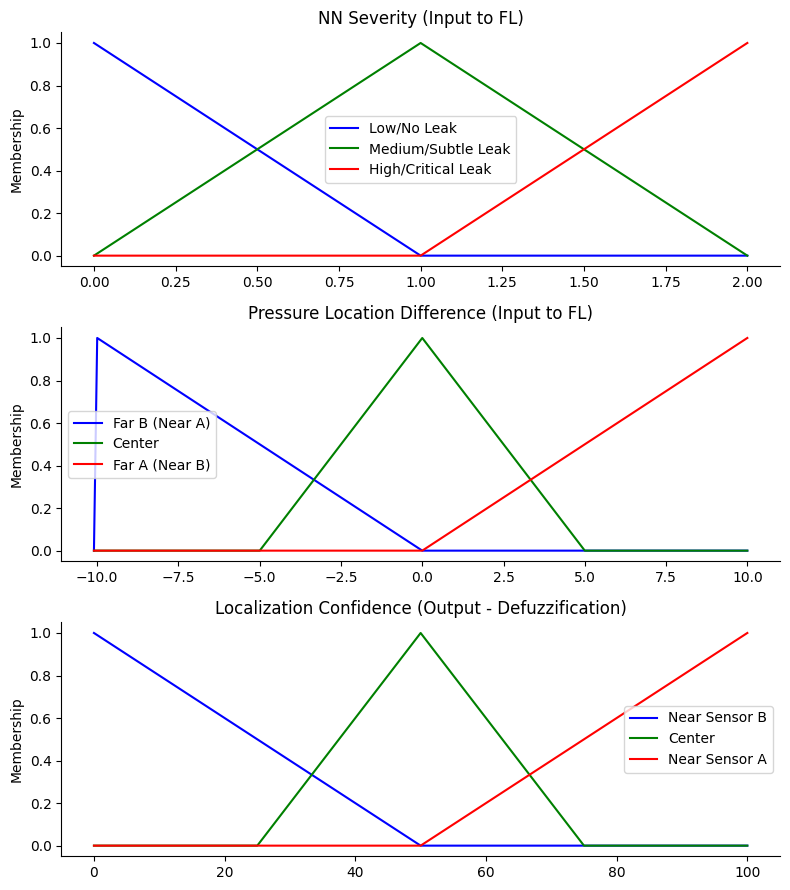

In [481]:
# Setup the plot area
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(8, 9))

# Plot NN_Severity
ax0.plot(nn_severity.universe, fuzz.interp_membership(nn_severity.universe, nn_severity['poor'].mf, nn_severity.universe), 'b', linewidth=1.5, label='Low/No Leak')
ax0.plot(nn_severity.universe, fuzz.interp_membership(nn_severity.universe, nn_severity['average'].mf, nn_severity.universe), 'g', linewidth=1.5, label='Medium/Subtle Leak')
ax0.plot(nn_severity.universe, fuzz.interp_membership(nn_severity.universe, nn_severity['good'].mf, nn_severity.universe), 'r', linewidth=1.5, label='High/Critical Leak')
ax0.set_title('NN Severity (Input to FL)')
ax0.legend()

# Plot Pressure_Loc_Diff
ax1.plot(pressure_loc_diff.universe, fuzz.interp_membership(pressure_loc_diff.universe, pressure_loc_diff['far_B'].mf, pressure_loc_diff.universe), 'b', linewidth=1.5, label='Far B (Near A)')
ax1.plot(pressure_loc_diff.universe, fuzz.interp_membership(pressure_loc_diff.universe, pressure_loc_diff['center'].mf, pressure_loc_diff.universe), 'g', linewidth=1.5, label='Center')
ax1.plot(pressure_loc_diff.universe, fuzz.interp_membership(pressure_loc_diff.universe, pressure_loc_diff['far_A'].mf, pressure_loc_diff.universe), 'r', linewidth=1.5, label='Far A (Near B)')
ax1.set_title('Pressure Location Difference (Input to FL)')
ax1.legend()

# Plot Localization_Confidence
ax2.plot(localization_confidence.universe, fuzz.interp_membership(localization_confidence.universe, localization_confidence['low'].mf, localization_confidence.universe), 'b', linewidth=1.5, label='Near Sensor B')
ax2.plot(localization_confidence.universe, fuzz.interp_membership(localization_confidence.universe, localization_confidence['medium'].mf, localization_confidence.universe), 'g', linewidth=1.5, label='Center')
ax2.plot(localization_confidence.universe, fuzz.interp_membership(localization_confidence.universe, localization_confidence['high'].mf, localization_confidence.universe), 'r', linewidth=1.5, label='Near Sensor A')
ax2.set_title('Localization Confidence (Output - Defuzzification)')
ax2.legend()

# Simple cleanup and display
for ax in (ax0, ax1, ax2):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel('Membership', fontsize=10)

plt.tight_layout()
plt.show()